In [1]:
# load libraries
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(patchwork)))
suppressWarnings(suppressPackageStartupMessages(library(ggsignif)))
# import ggplot theme
source("../../utils/figure_themes.r")

In [2]:
# path to the anova data
custom_aggregated_anova_genotype_df_path <- file.path("..","..","data","6.analysis_results","custom_aggregated_anova_results.parquet")
custom_aggregated_data_path <- file.path("..","..","data","5.converted_data","custom_aggregated_data.parquet")
fig_path <- file.path("..","figures","custom_aggregated")
# create the figure directory if it does not exist
if (!dir.exists(fig_path)){
  dir.create(fig_path, recursive = TRUE)
}

# read the data
custom_aggregated_data_df <- arrow::read_parquet(custom_aggregated_data_path)
head(custom_aggregated_data_df)

# read the anova data
custom_aggregated_anova_df <- arrow::read_parquet(custom_aggregated_anova_genotype_df_path)


Metadata_genotype,Metadata_replicate,AreaShape_Area,AreaShape_CentralMoment_0_0,AreaShape_CentralMoment_0_1,AreaShape_CentralMoment_0_2,AreaShape_CentralMoment_0_3,AreaShape_CentralMoment_1_0,AreaShape_CentralMoment_1_1,AreaShape_CentralMoment_1_2,⋯,Texture_SumEntropy_OP_3_02_256,Texture_SumEntropy_OP_3_03_256,Texture_SumVariance_OP_3_00_256,Texture_SumVariance_OP_3_01_256,Texture_SumVariance_OP_3_02_256,Texture_SumVariance_OP_3_03_256,Texture_Variance_OP_3_00_256,Texture_Variance_OP_3_01_256,Texture_Variance_OP_3_02_256,Texture_Variance_OP_3_03_256
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
high,1,1.192966,0.5964828,0.54175256,-0.04923743,0.7817362,2.1009152,-0.9278737,-0.04298225,⋯,-0.2082104,-0.11903633,-1.0917116,-0.52502679,-1.0866094,-0.54458881,-1.1151266,-0.5621014,-1.1179528,-0.5608718
high,10,2.477908,1.2389540,1.31962606,1.72236419,-1.7485946,0.1791951,-3.2895193,0.82527013,⋯,1.2939544,0.63535604,1.2613638,0.64209101,1.1875076,0.63527378,1.1157257,0.5484734,1.1219693,0.5477695
high,11,4.262414,2.1312071,1.26173108,1.42646941,0.5831822,1.8012069,-0.5413249,-0.16430652,⋯,1.3735418,0.67823043,1.1047649,0.57082297,1.0525320,0.54847464,0.9976509,0.4862685,1.0001664,0.4902130
high,12,2.402476,1.2012381,0.04988604,1.27911918,-0.9281710,-1.6528531,-1.9646186,0.10767961,⋯,0.6190094,0.30893327,-0.1095573,-0.05987619,-0.1967998,-0.06793023,-0.2075640,-0.1093674,-0.2021711,-0.1067718
high,13,2.389777,1.1948884,-1.10873607,-0.03446555,0.1017650,-1.3449799,-0.9673454,-0.79443383,⋯,0.1134128,0.04774139,-0.6503412,-0.29567384,-0.6420772,-0.32243559,-0.6968174,-0.3562547,-0.7005716,-0.3521677
high,14,4.553584,2.2767921,-4.77707191,1.69171903,0.2514737,-0.7138870,-3.1808175,0.11087396,⋯,2.0541319,1.02583400,2.5108502,1.27093366,2.4192843,1.24875506,2.3347969,1.1480302,2.3437433,1.1541288


## Genotype, side and identity level data

### ANOVA means

In [3]:

custom_aggregated_anova_df$log10_anova_p_value <- -log10(custom_aggregated_anova_df$anova_p_value)
# order the results by log10 anova p-value
custom_aggregated_anova_df <- custom_aggregated_anova_df %>% arrange(log10_anova_p_value)
# split the feature into 3 groups at "_"
custom_aggregated_anova_df$feature_type <- sapply(strsplit(custom_aggregated_anova_df$feature, "_"), function(x) x[1])
custom_aggregated_anova_df$feature_name <- sapply(strsplit(custom_aggregated_anova_df$feature, "_"), function(x) x[2])
head(custom_aggregated_anova_df)


group1,group2,meandiff,p-adj,lower,upper,reject,feature,anova_p_value,log10_anova_p_value,feature_type,feature_name
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
high,unsel,0.0825,0.9923,-1.6185,1.7835,FALSE,RadialDistribution_ZernikePhase_OP_7_5,0.9666994,0.01470857,RadialDistribution,ZernikePhase
high,wt,0.1815,0.9635,-1.5195,1.8825,FALSE,RadialDistribution_ZernikePhase_OP_7_5,0.9666994,0.01470857,RadialDistribution,ZernikePhase
unsel,wt,0.0991,0.9890,-1.6019,1.8001,FALSE,RadialDistribution_ZernikePhase_OP_7_5,0.9666994,0.01470857,RadialDistribution,ZernikePhase
high,unsel,-0.0133,0.9991,-0.8050,0.7785,FALSE,AreaShape_CentralMoment_1_0,0.9440693,0.02499612,AreaShape,CentralMoment
high,wt,0.0882,0.9602,-0.7035,0.8800,FALSE,AreaShape_CentralMoment_1_0,0.9440693,0.02499612,AreaShape,CentralMoment
unsel,wt,0.1015,0.9477,-0.6902,0.8932,FALSE,AreaShape_CentralMoment_1_0,0.9440693,0.02499612,AreaShape,CentralMoment


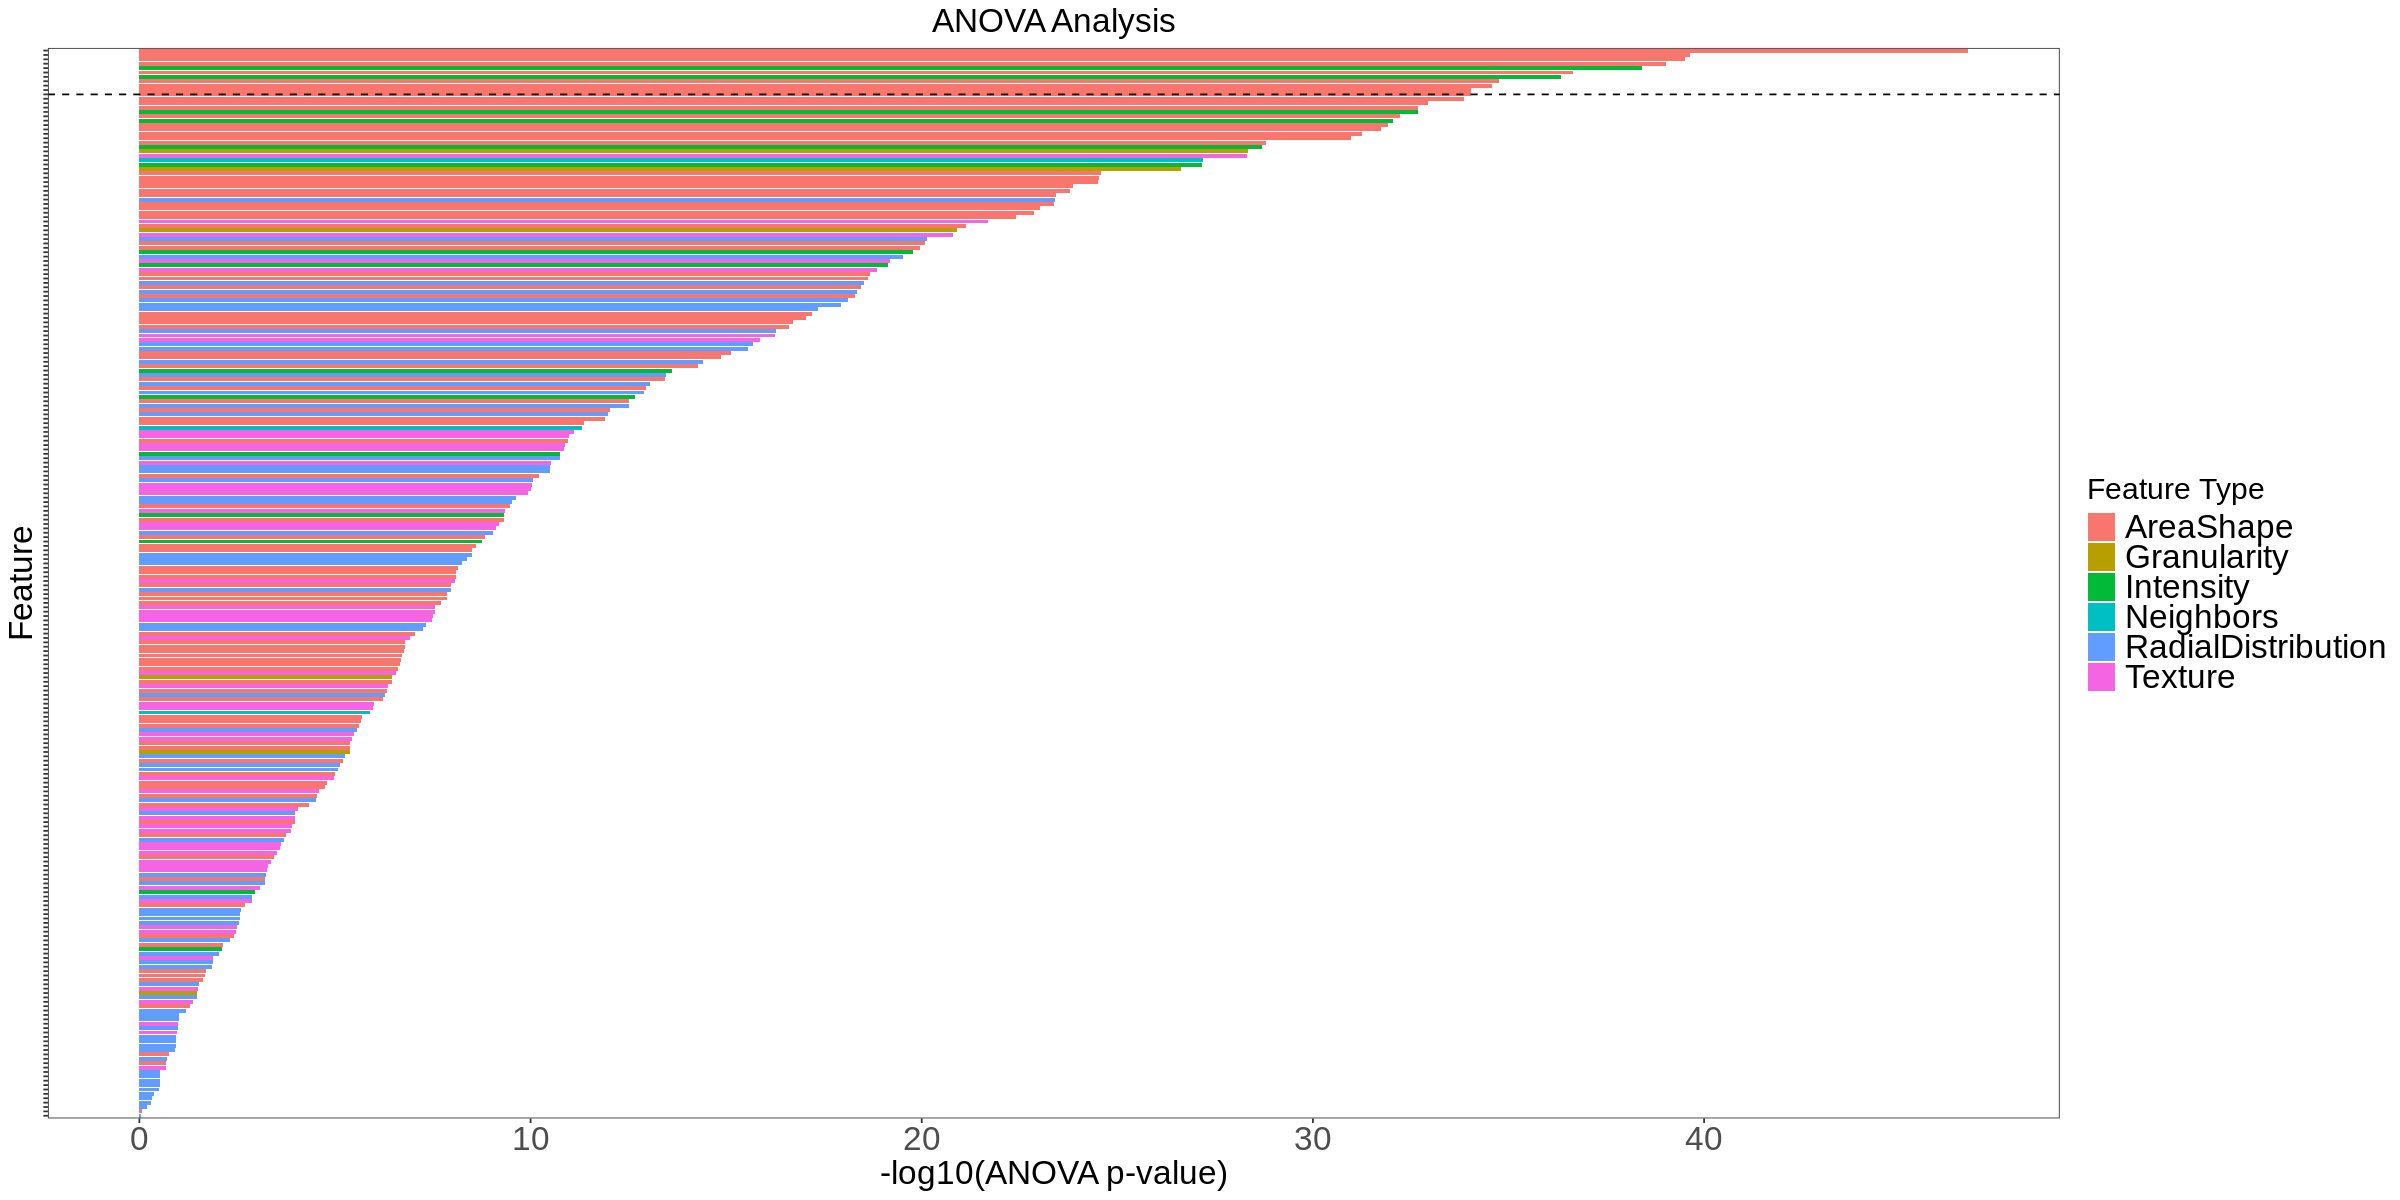

In [4]:
width <- 20
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
anova_plot <- (
    # order the results by log10 anova p-value
    ggplot(custom_aggregated_anova_df, aes(y = reorder(feature, log10_anova_p_value), x = log10_anova_p_value, fill = feature_type))
    + geom_bar(stat = "identity")
    # drop y axis labels
    + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    + labs(title = "ANOVA Analysis", y = "Feature", x = "-log10(ANOVA p-value)", fill = "Feature Type")
   
    + figure_theme


    + theme(axis.text.y = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank())
    + theme(axis.text.y = element_blank())
    + geom_hline(yintercept = length(unique(custom_aggregated_anova_df$feature))-10, linetype = "dashed", color = "black")
     
)
anova_plot
# save the plot
ggsave(file = "custom_aggregated_anova_plot.png", plot = anova_plot, path = file.path(fig_path), width = width, height = height, dpi = 600)

## Test for equality of variance 

In [5]:
# load levene data in 
custom_aggregated_levene_df_path <- file.path("..","..","data","6.analysis_results","custom_aggregated_levene_test_results.csv")
custom_aggregated_levene_df <- read.csv(custom_aggregated_levene_df_path)
# make a new column for ***
custom_aggregated_levene_df$significance <- ifelse(
    custom_aggregated_levene_df$levene_p_value < 0.001, "***", 
    ifelse(custom_aggregated_levene_df$levene_p_value < 0.01, "**", 
    ifelse(custom_aggregated_levene_df$levene_p_value < 0.05, "*", 
    "ns")
    )
)
head(custom_aggregated_levene_df)

,X,feature,levene_statistic,levene_p_value,group,significance
,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,909,RadialDistribution_ZernikePhase_OP_6_6,1.928452e-03,0.9980735,all,ns
2,90,AreaShape_Zernike_8_4,1.841247e-05,0.9966091,high_vs_unsel,ns
3,540,AreaShape_NormalizedMoment_3_3,4.582473e-05,0.9946505,unsel_vs_wt,ns
4,1,AreaShape_CentralMoment_0_0,5.003355e-05,0.9944103,high_vs_unsel,ns
5,920,RadialDistribution_ZernikePhase_OP_9_3,1.116004e-02,0.9889052,all,ns
6,248,AreaShape_CentralMoment_0_3,2.635471e-04,0.9871715,high_vs_wt,ns


### Variances

In [6]:
width <- 4
height <- 4
options(repr.plot.width = width, repr.plot.height = height)
# make a new column for the group1 and group2
custom_aggregated_anova_df$comparison <- paste(custom_aggregated_anova_df$group1, custom_aggregated_anova_df$group2, sep = " - ")

# order the results by anova p-value
custom_aggregated_anova_df <- custom_aggregated_anova_df %>% arrange(anova_p_value)
features <- unique(custom_aggregated_anova_df$feature)[1:20]
features
top_20_custom_aggregated_anova_df <- custom_aggregated_anova_df %>% filter(feature %in% features)
top_20_custom_aggregated_anova_df$log10_tukey_p_value <- -log10(top_20_custom_aggregated_anova_df$`p-adj`)
# make the genotype a factor
# replace the genotype values
custom_aggregated_data_df$Metadata_genotype <- gsub("wt", "Wild Type", custom_aggregated_data_df$Metadata_genotype)
custom_aggregated_data_df$Metadata_genotype <- gsub("unsel", "Mid-Severity", custom_aggregated_data_df$Metadata_genotype)
custom_aggregated_data_df$Metadata_genotype <- gsub("high", "High-Severity", custom_aggregated_data_df$Metadata_genotype)
custom_aggregated_data_df$Metadata_genotype <- factor(
    custom_aggregated_data_df$Metadata_genotype, 
    levels = c("Wild Type", "Mid-Severity", "High-Severity")
)
head(custom_aggregated_data_df)

[1] "AreaShape_Zernike_2_0"               
 [2] "AreaShape_Zernike_0_0"               
 [3] "AreaShape_MedianRadius"              
 [4] "AreaShape_MaximumRadius"             
 [5] "Intensity_MeanIntensityEdge_OP"      
 [6] "AreaShape_MinFeretDiameter"          
 [7] "Intensity_MaxIntensityEdge_OP"       
 [8] "AreaShape_NormalizedMoment_2_0"      
 [9] "AreaShape_MeanRadius"                
[10] "AreaShape_Area"                      
[11] "AreaShape_SpatialMoment_0_0"         
[12] "AreaShape_ConvexArea"                
[13] "AreaShape_MinorAxisLength"           
[14] "AreaShape_InertiaTensorEigenvalues_1"
[15] "Intensity_StdIntensityEdge_OP"       
[16] "AreaShape_HuMoment_0"                
[17] "Intensity_LowerQuartileIntensity_OP" 
[18] "AreaShape_EquivalentDiameter"        
[19] "AreaShape_SpatialMoment_1_0"         
[20] "AreaShape_CentralMoment_0_0"

Metadata_genotype,Metadata_replicate,AreaShape_Area,AreaShape_CentralMoment_0_0,AreaShape_CentralMoment_0_1,AreaShape_CentralMoment_0_2,AreaShape_CentralMoment_0_3,AreaShape_CentralMoment_1_0,AreaShape_CentralMoment_1_1,AreaShape_CentralMoment_1_2,⋯,Texture_SumEntropy_OP_3_02_256,Texture_SumEntropy_OP_3_03_256,Texture_SumVariance_OP_3_00_256,Texture_SumVariance_OP_3_01_256,Texture_SumVariance_OP_3_02_256,Texture_SumVariance_OP_3_03_256,Texture_Variance_OP_3_00_256,Texture_Variance_OP_3_01_256,Texture_Variance_OP_3_02_256,Texture_Variance_OP_3_03_256
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High-Severity,1,1.192966,0.5964828,0.54175256,-0.04923743,0.7817362,2.1009152,-0.9278737,-0.04298225,⋯,-0.2082104,-0.11903633,-1.0917116,-0.52502679,-1.0866094,-0.54458881,-1.1151266,-0.5621014,-1.1179528,-0.5608718
High-Severity,10,2.477908,1.2389540,1.31962606,1.72236419,-1.7485946,0.1791951,-3.2895193,0.82527013,⋯,1.2939544,0.63535604,1.2613638,0.64209101,1.1875076,0.63527378,1.1157257,0.5484734,1.1219693,0.5477695
High-Severity,11,4.262414,2.1312071,1.26173108,1.42646941,0.5831822,1.8012069,-0.5413249,-0.16430652,⋯,1.3735418,0.67823043,1.1047649,0.57082297,1.0525320,0.54847464,0.9976509,0.4862685,1.0001664,0.4902130
High-Severity,12,2.402476,1.2012381,0.04988604,1.27911918,-0.9281710,-1.6528531,-1.9646186,0.10767961,⋯,0.6190094,0.30893327,-0.1095573,-0.05987619,-0.1967998,-0.06793023,-0.2075640,-0.1093674,-0.2021711,-0.1067718
High-Severity,13,2.389777,1.1948884,-1.10873607,-0.03446555,0.1017650,-1.3449799,-0.9673454,-0.79443383,⋯,0.1134128,0.04774139,-0.6503412,-0.29567384,-0.6420772,-0.32243559,-0.6968174,-0.3562547,-0.7005716,-0.3521677
High-Severity,14,4.553584,2.2767921,-4.77707191,1.69171903,0.2514737,-0.7138870,-3.1808175,0.11087396,⋯,2.0541319,1.02583400,2.5108502,1.27093366,2.4192843,1.24875506,2.3347969,1.1480302,2.3437433,1.1541288


In [7]:
width <- 8
height <- 8

list_of_genotype_anova_plots_by_genotype <- list()

for (i in 1:length(features)){
    print(features[i])
    # get the top feature
    tmp <- custom_aggregated_data_df %>% select(c("Metadata_genotype", features[i]))
    # aggregate the data to get the mean and standard deviation of the top feature
    tmp <- tmp %>% group_by(Metadata_genotype) %>% summarise(mean = mean(!!as.name(features[i])), sd = sd(!!as.name(features[i])))

    # get the levene test result for the selected feature
    tmp_levene <- custom_aggregated_levene_df %>% filter(feature == features[i])
    WT_vs_high_significance <- tmp_levene %>% filter(group == "high_vs_unsel")
    WT_vs_unsel_significance <- tmp_levene %>% filter(group == "unsel_vs_wt")
    unsel_vs_high_significance <- tmp_levene %>% filter(group == "high_vs_wt")
    WT_vs_high_significance <- WT_vs_high_significance$significance
    WT_vs_unsel_significance <- WT_vs_unsel_significance$significance
    unsel_vs_high_significance <- unsel_vs_high_significance$significance

    # calculate the variance where variance = sd^2
    tmp$variance <- tmp$sd^2
    title <- gsub("_", " ", features[i])

    # get the max value of the variance
    max_var <- max(tmp$variance)
    # add 0.3 to the max value to get the y max
    max_var_plot <- max_var + 3


    # plot the variability of the top feature
    var_plot <- (
        ggplot(tmp, aes(x = Metadata_genotype, y = variance, fill = Metadata_genotype)) 
        + geom_bar(stat = "identity")
        + theme(axis.text.x = element_text(angle = 90, hjust = 1))
        + labs(title = title, x = "Genotype", y = "Variance", fill = "Genotype")
        + theme_bw()
        + figure_theme
     
        + geom_signif(
            comparisons = list(c("High-Severity","Mid-Severity")), 
            annotations = unsel_vs_high_significance,
            textsize = 7,
            y_position = c(max_var+0.5, max_var+1)        
            ) 
        + geom_signif(
            comparisons = list(c("Wild Type","Mid-Severity")), 
            annotations = WT_vs_unsel_significance, 
            textsize = 7,
            y_position = c(max_var+0.5, max_var+1)        
            )
        + geom_signif(
            comparisons = list(c("High-Severity","Wild Type")), 
            annotations = WT_vs_high_significance,
            textsize = 7,
            y_position = c(max_var+1.5, max_var+2)        
        )
           # remove the legend
        + theme(legend.position = "none")
        + ylim(0,max_var_plot)
    )
    # save var plot
    ggsave(file = paste0("custom_aggregated_", features[i], "_variance_plot_genotype.png"), plot = var_plot, path = file.path(fig_path), width = width, height = height, dpi = 600)

    list_of_genotype_anova_plots_by_genotype[[i]] <- var_plot
}

[1] "AreaShape_Zernike_2_0"


[1] "AreaShape_Zernike_0_0"


[1] "AreaShape_MedianRadius"


[1] "AreaShape_MaximumRadius"


[1] "Intensity_MeanIntensityEdge_OP"


[1] "AreaShape_MinFeretDiameter"


[1] "Intensity_MaxIntensityEdge_OP"


[1] "AreaShape_NormalizedMoment_2_0"


[1] "AreaShape_MeanRadius"


[1] "AreaShape_Area"


[1] "AreaShape_SpatialMoment_0_0"


[1] "AreaShape_ConvexArea"


[1] "AreaShape_MinorAxisLength"


[1] "AreaShape_InertiaTensorEigenvalues_1"


[1] "Intensity_StdIntensityEdge_OP"


[1] "AreaShape_HuMoment_0"


[1] "Intensity_LowerQuartileIntensity_OP"


[1] "AreaShape_EquivalentDiameter"


[1] "AreaShape_SpatialMoment_1_0"


[1] "AreaShape_CentralMoment_0_0"


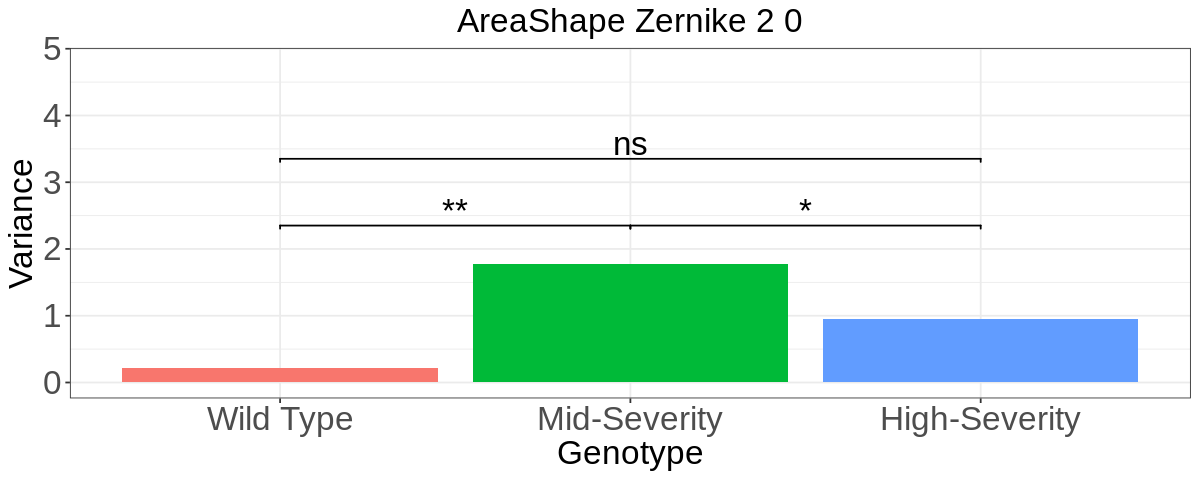

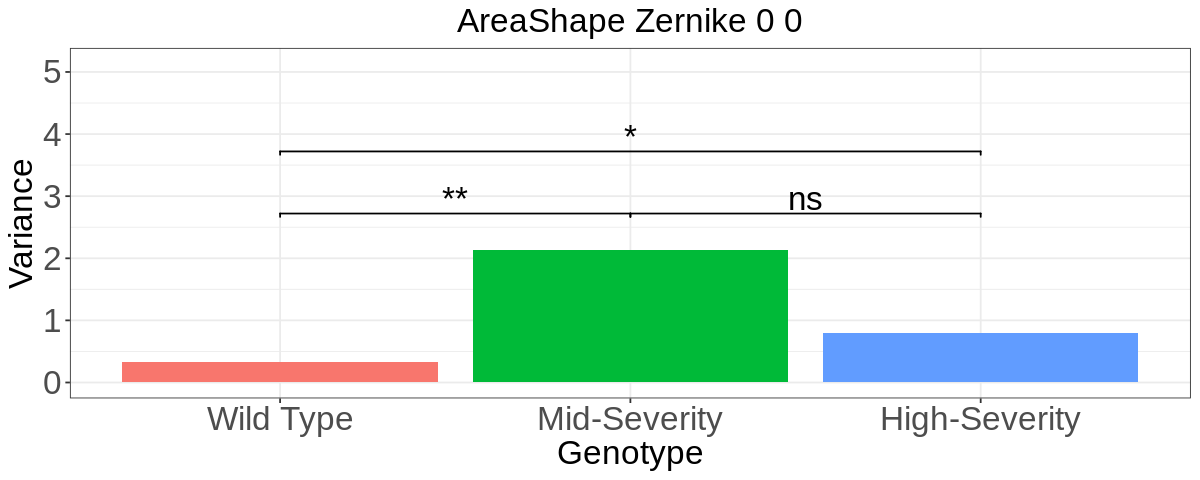

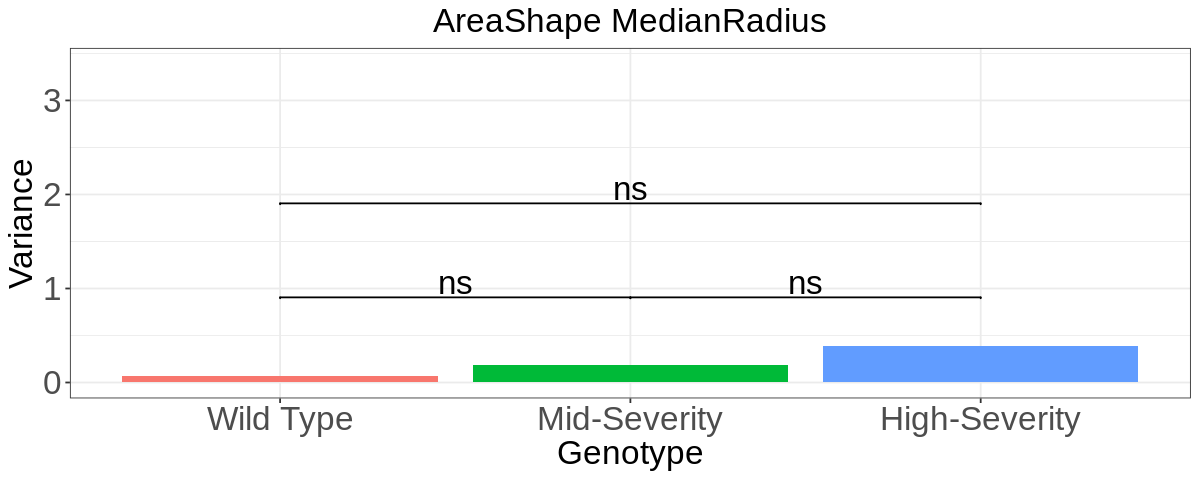

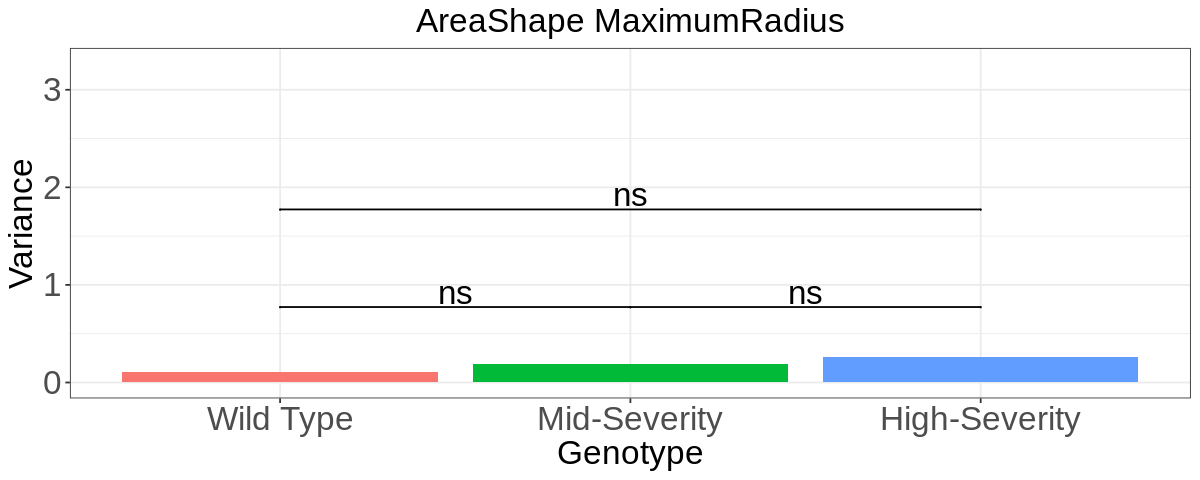

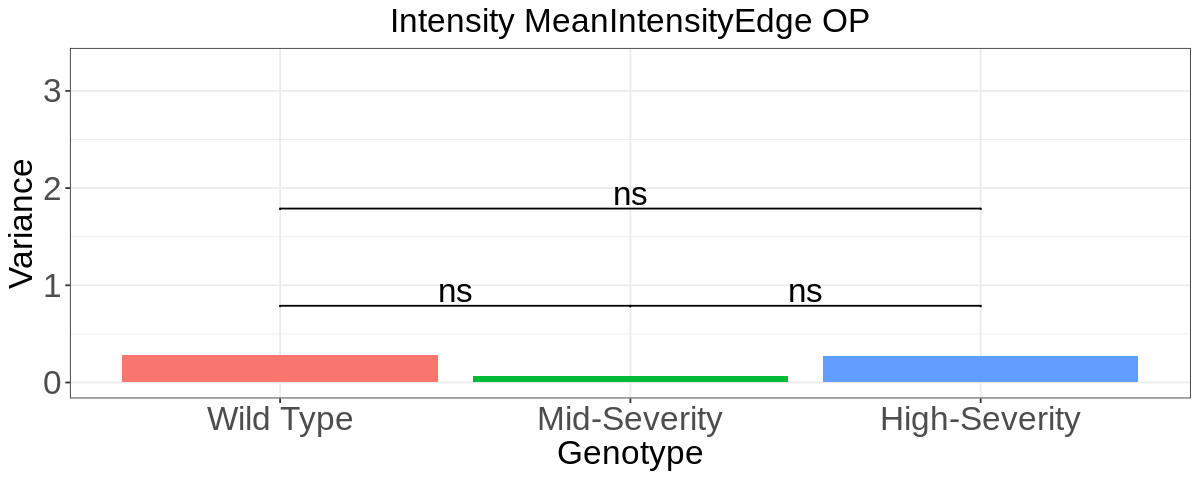

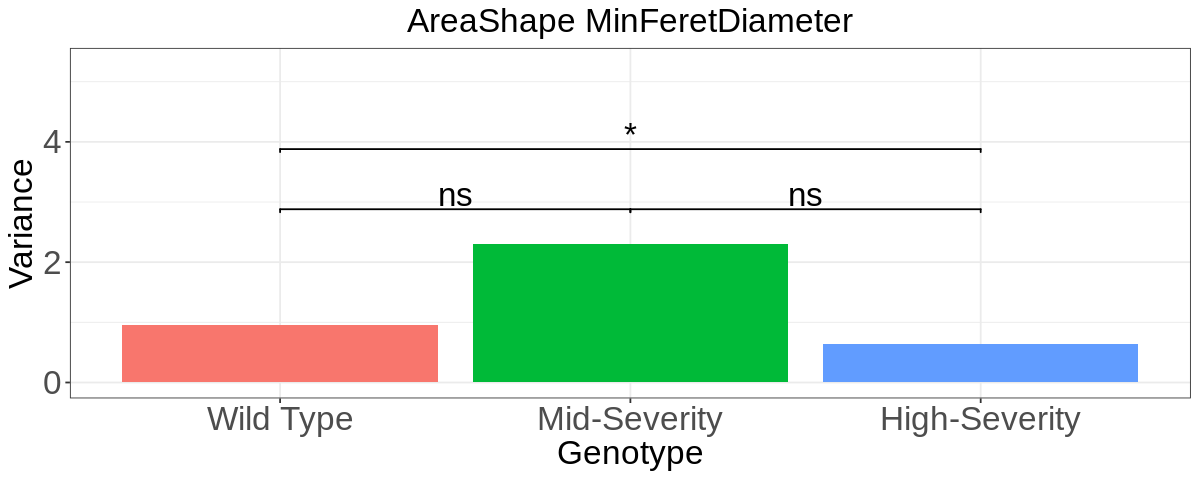

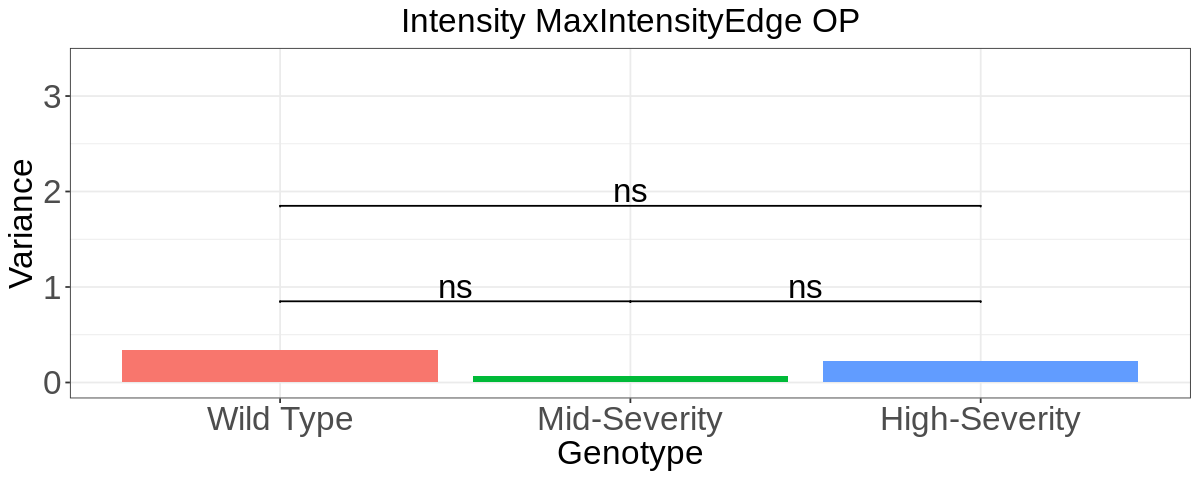

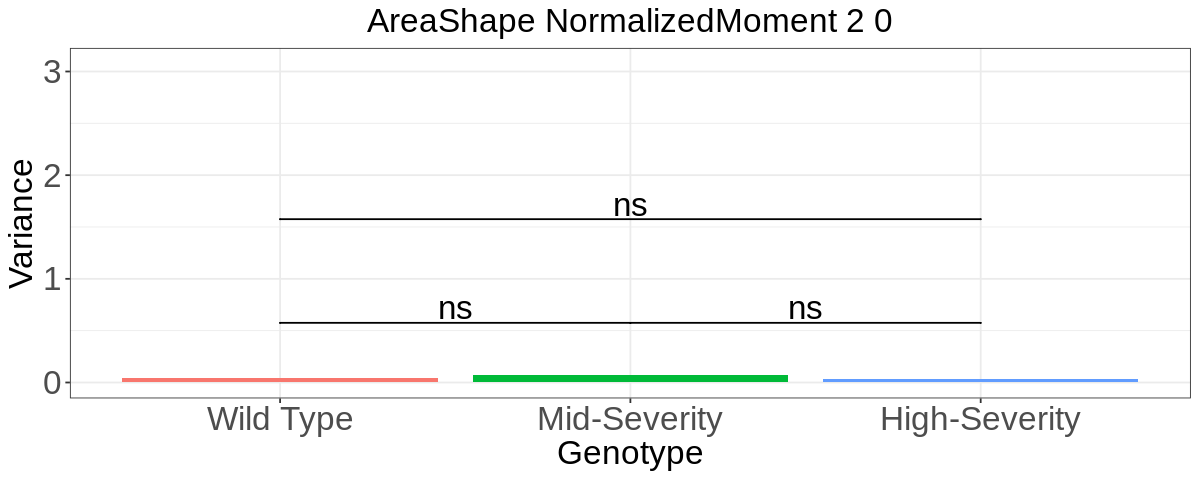

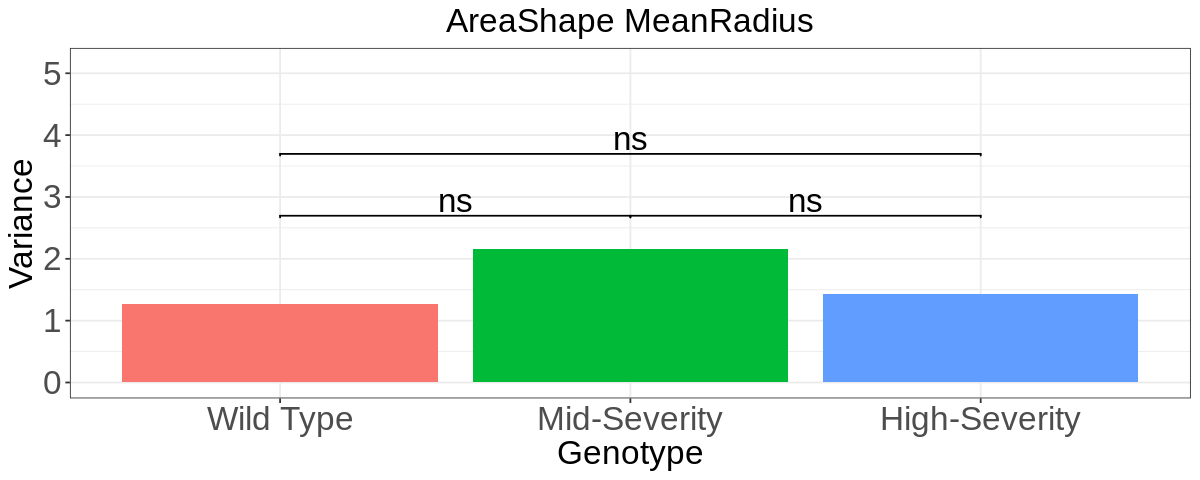

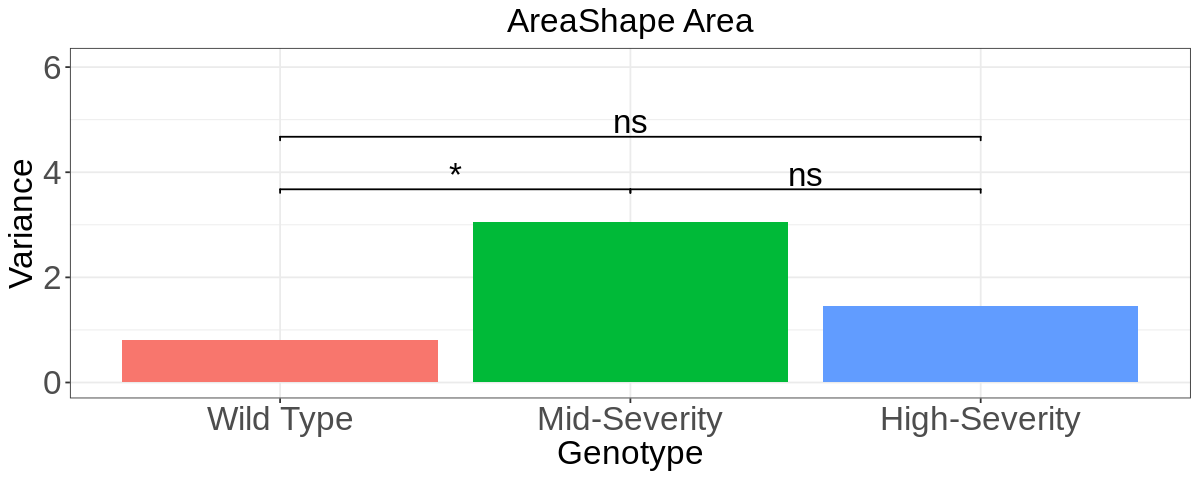

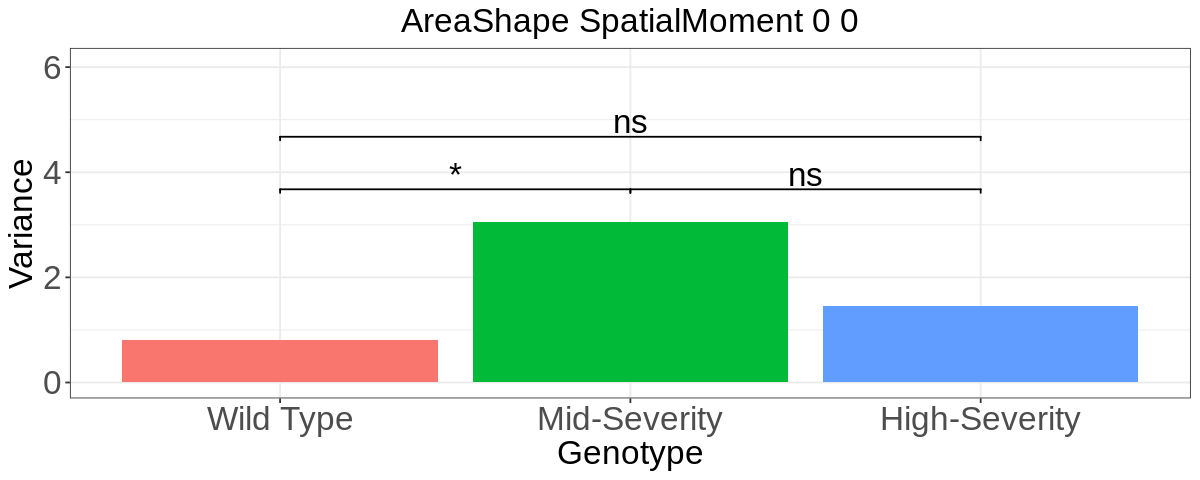

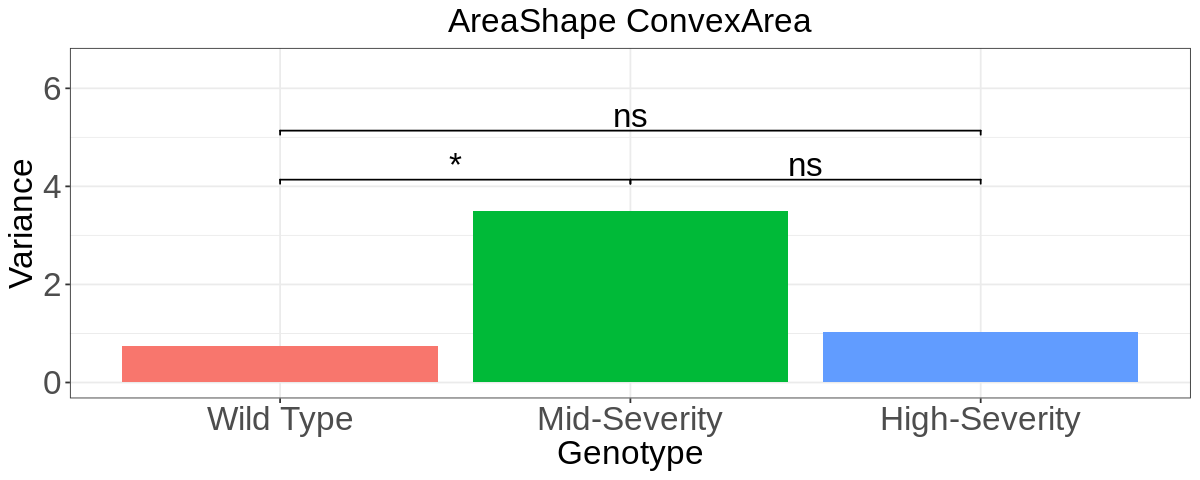

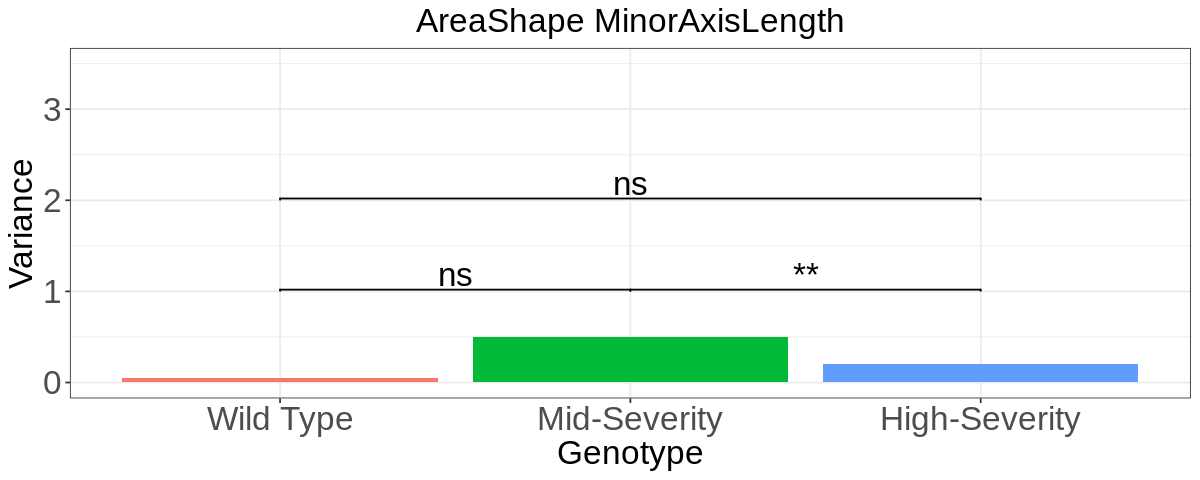

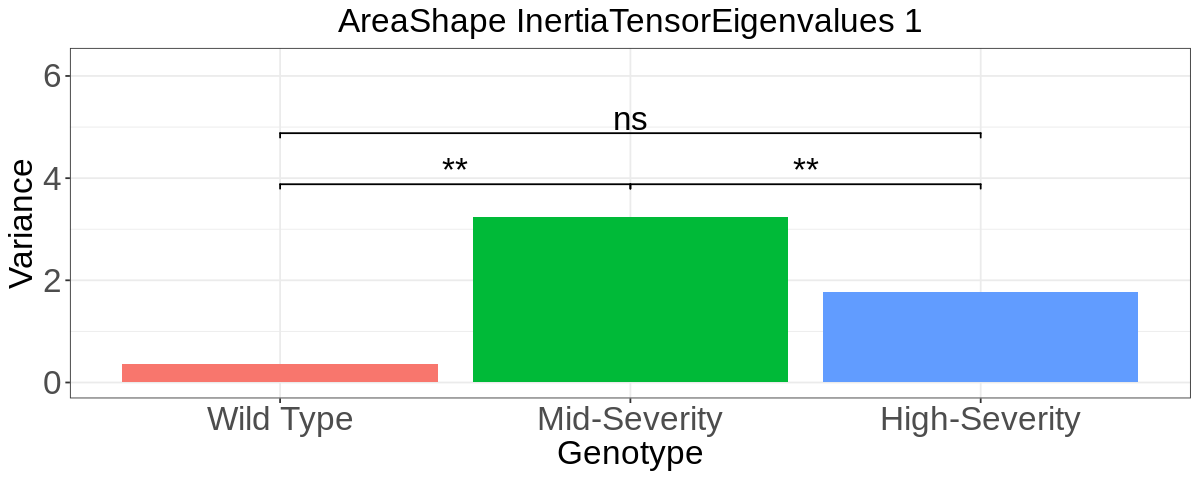

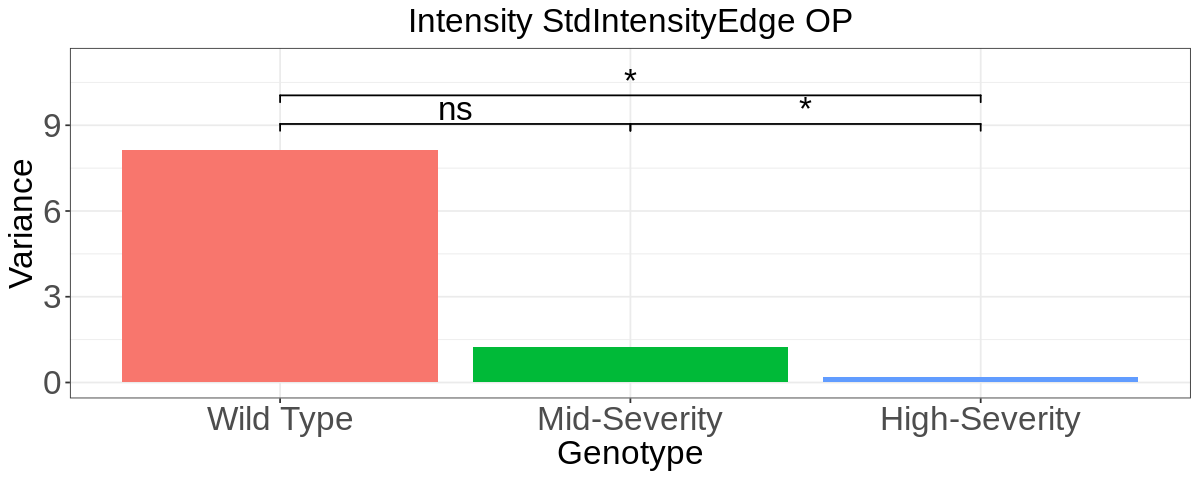

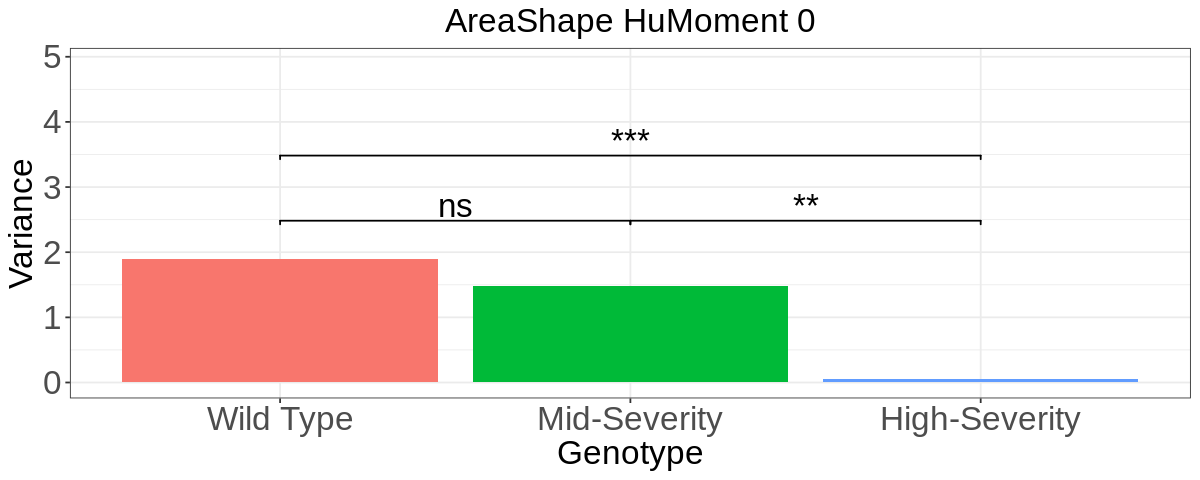

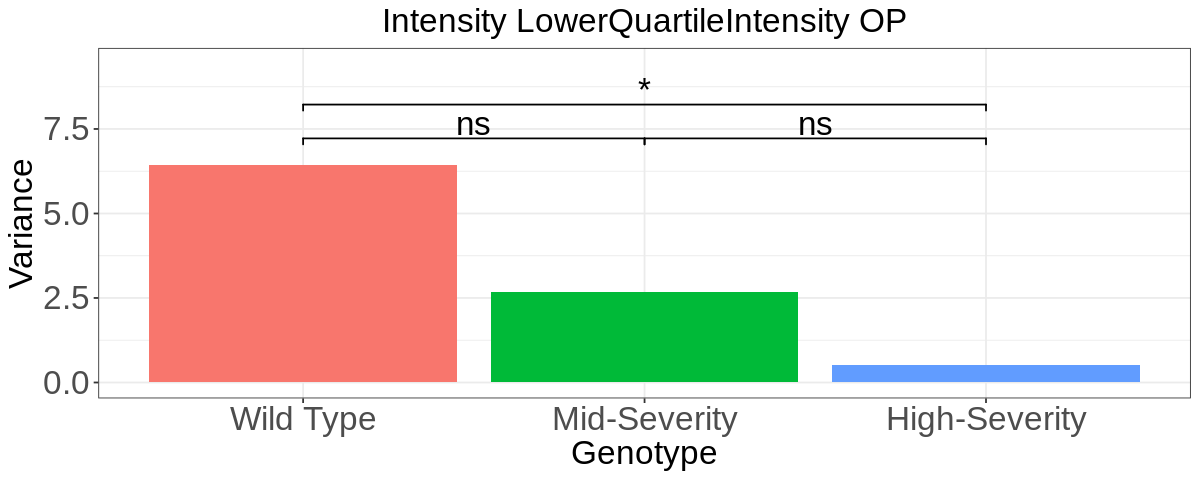

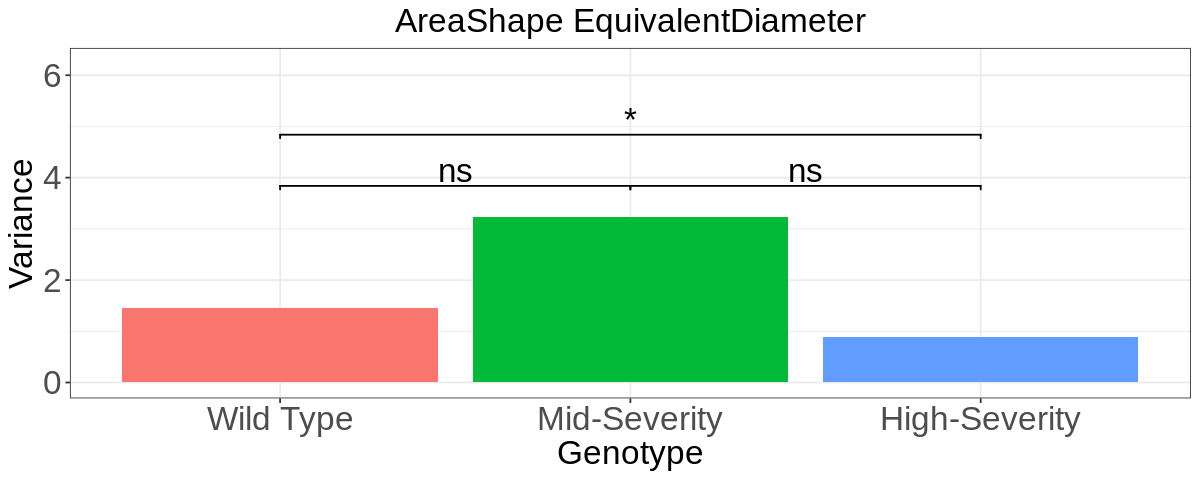

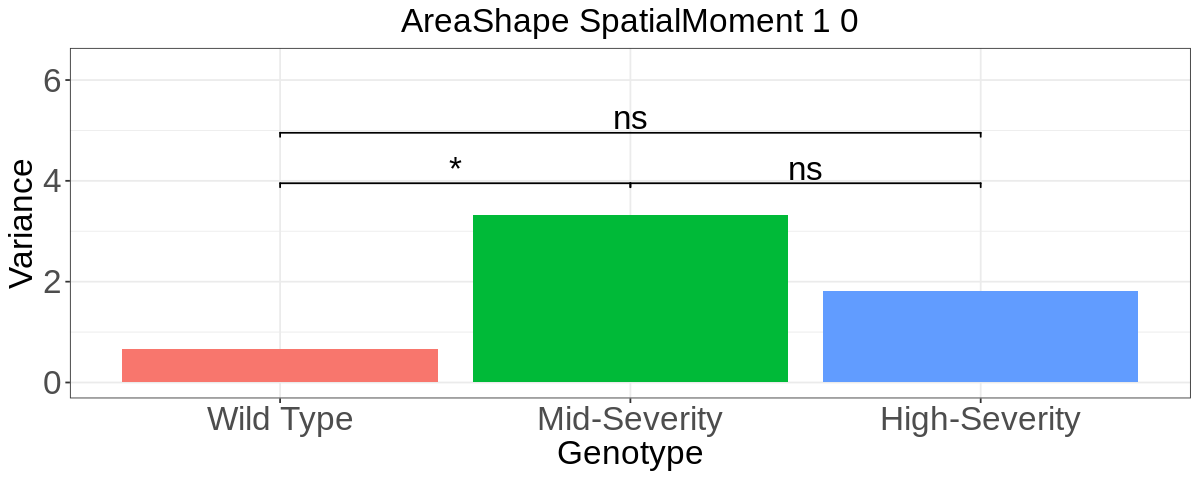

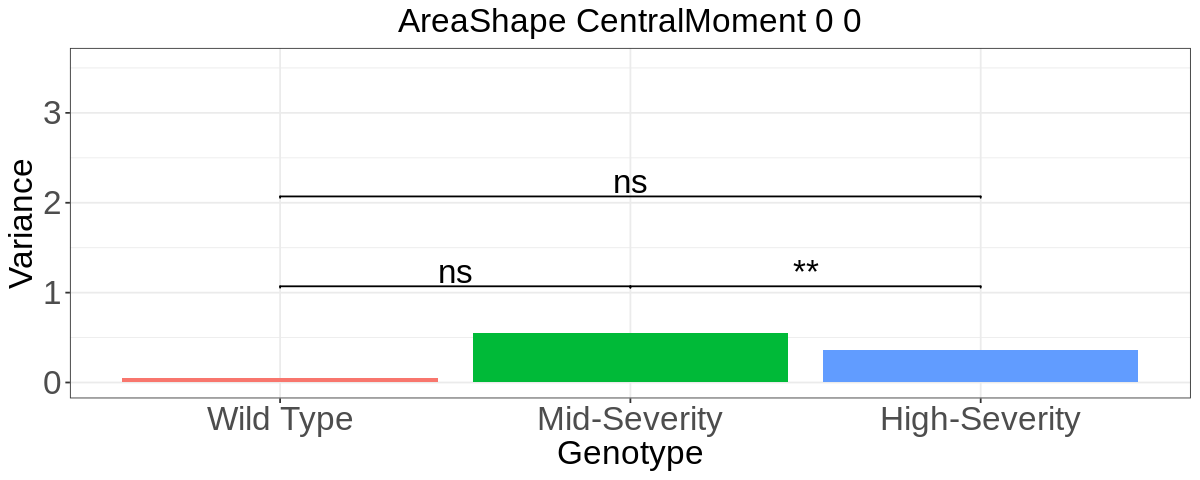

In [8]:
width <- 10
height <- 4
options(repr.plot.width = width, repr.plot.height = height)
list_of_genotype_anova_plots_by_genotype[[1]]
list_of_genotype_anova_plots_by_genotype[[2]]
list_of_genotype_anova_plots_by_genotype[[3]]
list_of_genotype_anova_plots_by_genotype[[4]]
list_of_genotype_anova_plots_by_genotype[[5]]
list_of_genotype_anova_plots_by_genotype[[6]]
list_of_genotype_anova_plots_by_genotype[[7]]
list_of_genotype_anova_plots_by_genotype[[8]]
list_of_genotype_anova_plots_by_genotype[[9]]
list_of_genotype_anova_plots_by_genotype[[10]]
list_of_genotype_anova_plots_by_genotype[[11]]
list_of_genotype_anova_plots_by_genotype[[12]]
list_of_genotype_anova_plots_by_genotype[[13]]
list_of_genotype_anova_plots_by_genotype[[14]]
list_of_genotype_anova_plots_by_genotype[[15]]
list_of_genotype_anova_plots_by_genotype[[16]]
list_of_genotype_anova_plots_by_genotype[[17]]
list_of_genotype_anova_plots_by_genotype[[18]]
list_of_genotype_anova_plots_by_genotype[[19]]
list_of_genotype_anova_plots_by_genotype[[20]]
